## Confidence intervals for system evaluation using the bootstrapping approach

This notebook contains the code needed to create confidence intervals with the bootstrapping approach
for (almost) any task, dataset or metric. Four things are required to run this code:

* **Test samples**: an array, dataframe or object that can be indexed with an array of integers to select the samples for each bootstrap set. Note that, here, the term sample refers to the output of the system for each original sample input to the system. Those outputs are all that is needed to compute the performance metric.
* **Labels**: an array, dataframe or object that can be indexed to select the labels for the samples above.
* **Conditions**: an array of integers indicating the conditions of the samples (e.g., the speaker identity). All samples with the same condition will be sampled together when doing bootstrapping.
* **Metric**: The metric to be used for assessing performance. A method that takes samples and labels and computes a scalar value. 
  
The samples and the labels can be as simple or as complex as your task requires. For example: 

* In simple **classification tasks** like emotion recognition, each sample is the vector of scores (or the decision, depending on the metric we want to compute) generated by the system for a given input waveform, the label is the class of the sample, and the condition may be speaker or recording session of the waveform.
* In **automatic speech recognition**, each sample is the transcription generated by the system for a given waveform, the label is the ground truth transcription for that waveform, and the condition could be speaker in the waveform. 
* In **segmentation tasks** like speech activity detection, the sample would be the segmentation generated by the system for a waveform and the label would be the ground truth segmentation. In this case, if the waveforms are chunks extracted from longer waveforms, the condition of a sample should be given by the waveform from which the chunk was extracted.
* In **speaker verification**, each sample is a trial (enrollment + test samples) and the label is either "impostor" or "target". For this task, though, bootstrapping by condition is harder because both sides have different conditions (the speaker or session the waveforms come from). The code in this repository cannot handle this particular case. Instead, joint bootstrapping is needed. Please see the code in the [DCA-PLDA github repository](https://github.com/luferrer/DCA-PLDA/blob/master/dca_plda/scores.py) (compute_performance_with_confidence_intervals method) for an example of how to do joint bootstrapping for speaker verification.  





In [1]:
pip instlal git+https://github.com/pabloriera/ConfidenceIntervals.git@scikit_friendly

In [11]:
import numpy as np
import sklearn.metrics
from confidence_intervals import Bootstrap, get_bootstrap_indices
from confidence_intervals.utils import create_data

In [12]:
# Create a toy dataset. Here the samples are simply the decisions made by the system.
decisions, labels, conditions = create_data(200, 200, 10)
num_bootstraps = 1000
alpha = 5 #%
num_samples = len(labels)

metric =  sklearn.metrics.accuracy_score

In [13]:
metric_values = []
for nb in np.arange(num_bootstraps):
    indices = get_bootstrap_indices(num_samples, conditions=conditions, random_state=nb)
    metric_values.append(metric(labels[indices], decisions[indices]))
np.percentile(metric_values, alpha/2), np.percentile(metric_values, 100-alpha/2)

(0.7708333333333334, 0.8504706677175994)

In [14]:
# Compute the confidence interval with scikit friendly API
bs = Bootstrap(metric=metric, num_bootstraps=1000)
bs.fit(len(labels), conditions)
metric_values = bs.transform(decisions, labels)
bs.get_conf_int(print_result=True)

Confidence interval:  0.77   0.85


(0.7708333333333334, 0.8504706677175994)

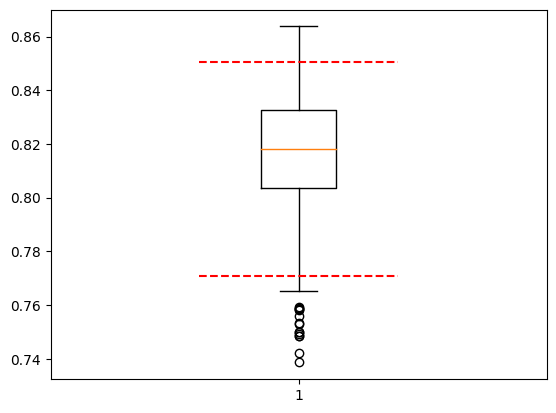

In [15]:
# Plot metric values distribution in a boxplot
import matplotlib.pyplot as plt
plt.boxplot(metric_values);
plt.hlines(bs._ci[0], 0.8, 1.2, linestyles='dashed', colors='red')
plt.hlines(bs._ci[1], 0.8, 1.2, linestyles='dashed', colors='red')
plt.show()